In [1]:
from trikde.pdfs import DensitySamples, IndepdendentLikelihoods
from trikde.triangleplot import TrianglePlot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
means = [0.55, 0.8, 0.45]
sigma_11 = 0.15 ** 2
sigma_22 = 0.2 ** 2
sigma_33 = 0.12 ** 2
sigma_12 = - (0.09 ** 2)
sigma_23 = 0.08 ** 2
sigma_13 = 0.07 ** 2

cov = np.array([[sigma_11, sigma_12, sigma_13], 
       [sigma_12, sigma_22, sigma_23], 
       [sigma_13, sigma_23, sigma_33]])
nsamples = 1000
samples = np.random.multivariate_normal(means, cov, nsamples)
assert np.linalg.det(cov) > 0
data_list = [samples]
param_names = ['p1', 'p2', 'p3']
weight_list = None
param_ranges = [[0., 1.25], [0., 1.25], [0., 1.25]]
nbins = 15
use_kde = False
density_samples_no_kde = DensitySamples(data_list, param_names, weight_list, param_ranges, 
                                        nbins=nbins, use_kde=False)
density_samples_with_kde = DensitySamples(data_list, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True)
# the kernel density likelihood will in general depend on the bandwidth; it is difficult to know a priori what
# value is appropriate, especially for non-gaussian distributions
density_samples_with_kde_2 = DensitySamples(data_list, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True, bandwidth_scale=0.1)

independent_densities_no_kde = IndepdendentLikelihoods([density_samples_no_kde])
independent_densities_with_kde = IndepdendentLikelihoods([density_samples_with_kde])
independent_densities_with_kde_2 = IndepdendentLikelihoods([density_samples_with_kde_2])

## Plot the distributions

Text(0,0.5,'custom y label')

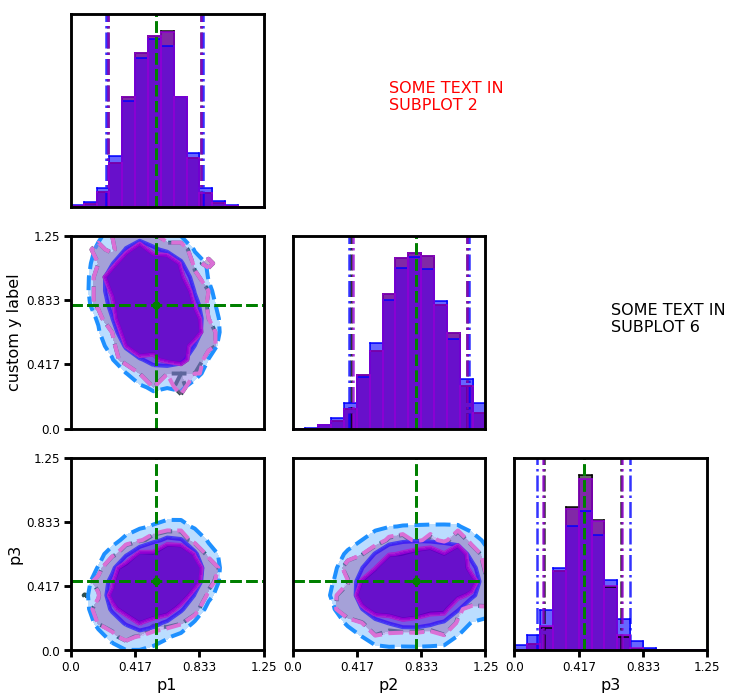

In [3]:
truths = {'p1': means[0], 'p2': means[1], 'p3': means[2]}
pdf_list = [independent_densities_no_kde, 
                        independent_densities_with_kde, 
                        independent_densities_with_kde_2]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

# triplot.make_triplot returns a list of the subplots, which can be individually manipulated
axes_list[1].annotate('SOME TEXT IN\nSUBPLOT 2', xy=(0.5, 0.5), xycoords='axes fraction', color='r', fontsize=16)
axes_list[5].annotate('SOME TEXT IN\nSUBPLOT 6', xy=(0.5, 0.5), xycoords='axes fraction', color='K', fontsize=16)
axes_list[3].set_ylabel('custom y label')

## Multiplying indepdent pdfs

### The DensitySamples class represents a single independent likelihood. If a list of these classes is passed to IndepdendentLikelihoods, then each instance of DensitySamples will be interpreted as an independent pdf and they will be multiplied together

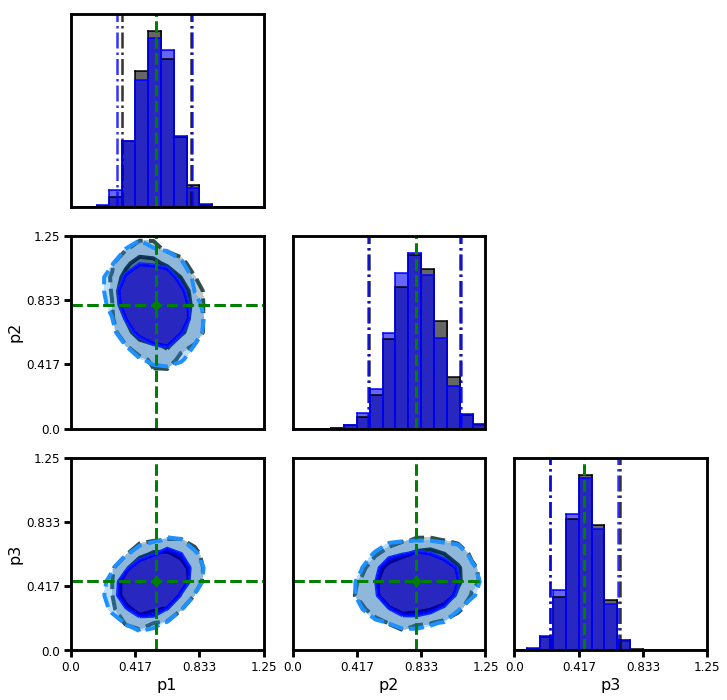

In [4]:
inv = 2 * np.linalg.inv(cov)
cov_product = np.linalg.inv(inv)
nsamples = 1000
samples_product = np.random.multivariate_normal(means, cov_product, nsamples)
data_list = [samples_product]
density_samples_product_with_kde = DensitySamples(data_list, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True)

independent_likelihood_product_from_samples = IndepdendentLikelihoods([density_samples_product_with_kde])
independent_likelihood_product_from_pdfs = IndepdendentLikelihoods([density_samples_with_kde, 
                                                                    density_samples_with_kde])

pdf_list = [independent_likelihood_product_from_samples, 
            independent_likelihood_product_from_pdfs]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

## Visualize distributions themselves

### At the end of the day this package is a fancy way of visualizing multi-dimensional histograms. You can plot the histograms themselves by setting filled_contours = False

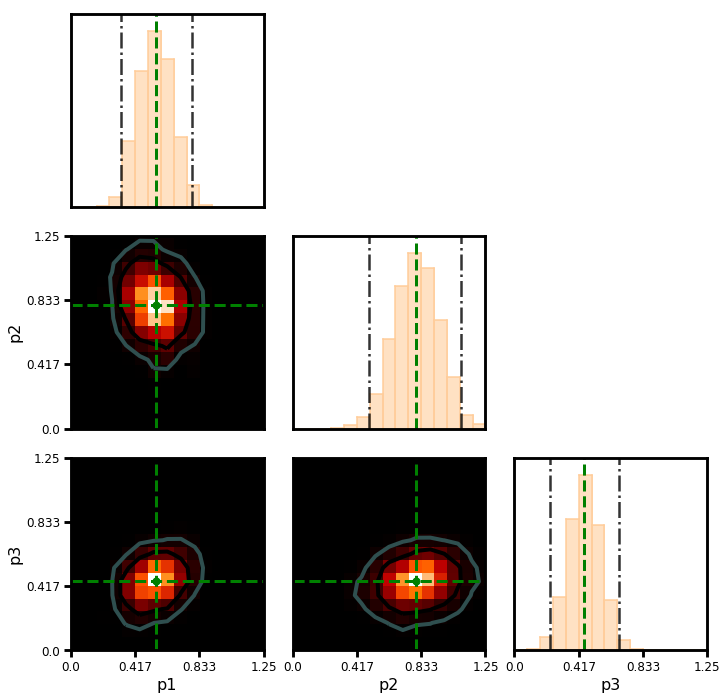

In [5]:
fig = plt.figure(1)
pdf_list = [independent_likelihood_product_from_samples]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths, filled_contours=False)
plt.show()

## Importance sampling
You can re-weight samples by specifying the weight_list option (default is None). The weight list must be the same length as data_list (first entry into density samples), and each element of weight_list must have len = data_list[i].shape[0] 

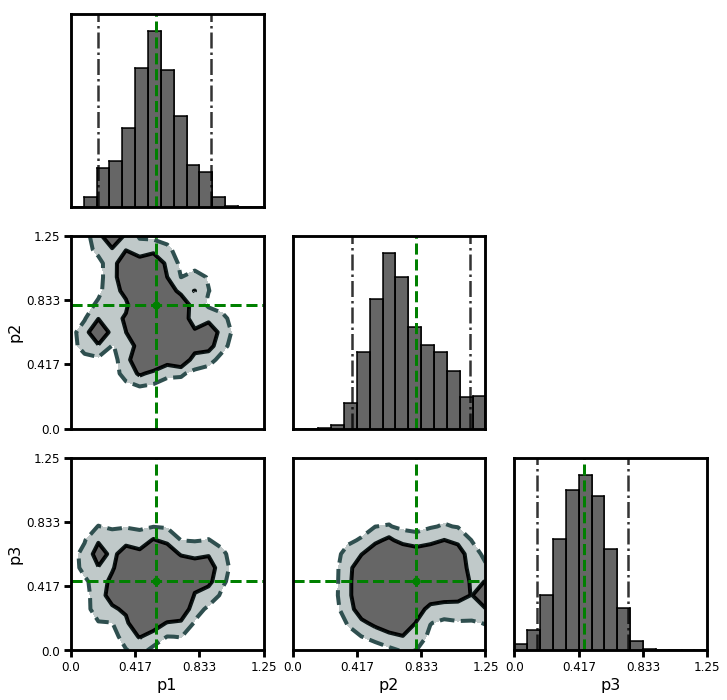

In [6]:
mu, s = 0.85, 0.05
weight_list = [np.exp(-0.5 * (mu - data_list[0][:,0])**2 / s**2)]
data_list = [samples]
density_samples_with_kde = DensitySamples(data_list, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True)
independent_densities_with_kde = IndepdendentLikelihoods([density_samples_with_kde])

triplot = TrianglePlot([independent_densities_with_kde])
axes_list = triplot.make_triplot(truths=truths)